# Sample usage of OpenAI API

In this notebook, we'll share the processing of how we utilized OpenAI APIs to process our lyrics, including:

- Token Calculation
- Obtain Embeddings
- Code lyrics into relevant Themes 

### Prep -- obtain OpenAI API Key and load the package

- Note: to run this, please set the API key as an environment variable in your system (on *Windows*: name after `OPENAI_API_KEY`) -- this is a safe measure to avoid leak your key during commit. 
- Otherwise, you can replace the key here `api_key = ..(YOUR KEY)..`

In [1]:
from openai import OpenAI

In [2]:
import os
client = OpenAI(api_key = os.environ['OPENAI_API_KEY'])

### Load lyric dataset

In [3]:
import pandas as pd
import json

In [4]:
with open('all_song_lyrics_dict_cleaned.json', 'r') as json_file:
    all_song_lyrics_dict = json.load(json_file)

In [5]:
dict_size = len(all_song_lyrics_dict) # we have 3k+ unique songs
dict_size

30851

In [6]:
# transform the dictionary into a dataframe: key = song name, value = lyrics

df = pd.DataFrame(list(all_song_lyrics_dict.items()),columns = ['song','lyrics'])

df.head()

,song,lyrics
0,Glory - Common & John Legend,\n\nOne day when the glory comes\nIt will be o...
1,Glory And Gore - Lorde,\n\nThere's a humming in the restless summer a...
2,Glory Bound - The Grass Roots,All the sun on the outside\nDoesn't touch what...
3,Glory Days - Bruce Springsteen,\n\nOh yeah\nC'mon\nWooh\nHuh\n\nI had a frien...
4,Glory Glory - The Rascals,"I saw a child, he was carryin' a light\nI aske..."


In [7]:
## see a distribution of song lengths
df['lyrics'].apply(len).describe()


count     30851.000000
mean       9652.640692
std       53593.465180
min           1.000000
25%        1010.000000
50%        1492.000000
75%        2448.500000
max      824531.000000
Name: lyrics, dtype: float64

### Some remarks about Raw Lyrics dataset

It is obvious that the rule-based cleaning cannot handle everything. Based on the length distribution:
- There are some lyrics that are too short --- e.g. the length of *1* is definitely problematic
- Also, there are lyrics that are too long --- this happened frequently during API request, where irrelevant/false infomation beyond lyrics were curated

In [8]:
df['lyrics'].apply(len).quantile(0.94)

19404.0

In [9]:
# see 95th percentile of song lengths
df['lyrics'].apply(len).quantile(0.93)

12799.5

In [10]:
# see 5th percentile of song lengths
df['lyrics'].apply(len).quantile(0.04)

133.0

- 94 percentile around 19000 characters
- 90 percentile around 4300 character

- 4 percentile around 150 characters
- 5 percentile around 400 character

Those more than 5000 characters are likely problematics --- theses are lyrics not essays :3



After EDA, we decided to drop the bottom 5 percentile and top 10 percentile based on the length:
- It is very likely a lyric with fewer than 200 characters are not collected correctly. 
- For longer lyrics, e.g. when lyrics length exceed 5000 characters, more than 50% of the occurances include false data (e.g. book pages, advertisement, random web pages..) Also, consider API calls is cost by token count, it is wise to exclude those *longer* ones when we don't have a better, effective way to clean and sample from them.

In [61]:
# drop the top 10% and bottom 5% of song lengths

df_drop = df[df['lyrics'].apply(len) > df['lyrics'].apply(len).quantile(0.05)]

df_drop = df_drop[df_drop['lyrics'].apply(len) < df['lyrics'].apply(len).quantile(0.90)]

In [62]:
df_drop['lyrics'].apply(len).describe()

count    26221.000000
mean      1662.119294
std        858.645227
min        423.000000
25%       1033.000000
50%       1437.000000
75%       2082.000000
max       4374.000000
Name: lyrics, dtype: float64

In [63]:
df_drop['lyrics'].apply(len).sum()

43582430

In [64]:
df_drop.shape ## Not too bad -- there are around 2.6k songs left

(26221, 2)

### Counting Token

- This is essential so you keep your expediture in check

In [13]:
import tiktoken

In [14]:
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

Here is an example of how to keep track of a single song token length --- we'll need to pay base on it

In [15]:
import random
# sample lyrics randomly collected from the dataset
lyrics_1 = df['lyrics'][random.randint(0, dict_size)]
# lyrics_2 = df['lyrics'][random.randint(0, dict_size)]
# lyrics_3 = df['lyrics'][random.randint(0, dict_size)]

In [16]:
print(lyrics_1) 

We shall overcome
We shall overcome
We shall overcome, some day
Oh, deep in my heart
I do believe
We shall overcome, some day
We'll walk hand in hand
We'll walk hand in hand
We'll walk hand in hand, some day
Oh, deep in my heart
We shall live in peace
We shall live in peace
We shall live in peace, some day
Oh, deep in my heart
We shall all be free
We shall all be free
We shall all be free, some day
Oh, deep in my heart
We are not afraid
We are not afraid
We are not afraid, TODAY
Oh, deep in my heart
We shall overcome
We shall overcome
We shall overcome, some day
Oh, deep in my heart
I do believe


In [17]:
len(lyrics_1) ## character length of the lyrics

602

In [18]:
lyrics_1_tokens = encoding.encode(lyrics_1)
len(lyrics_1_tokens) # token count

169

Now, we can apply the same thing to all the unique songs

In [65]:
# get the sum of the tokens for the entire dataframe

df_drop['lyrics_tokens'] = df_drop['lyrics'].apply(lambda x: encoding.encode(x))

df_drop['lyrics_tokens'].apply(len).describe()

count    26221.000000
mean       473.403417
std        265.770806
min         92.000000
25%        282.000000
50%        396.000000
75%        600.000000
max       3542.000000
Name: lyrics_tokens, dtype: float64

In [66]:
df_drop['lyrics_tokens'].apply(len).sum() ## 12 million tokens to be processed

12413111

#### 12 million token of lyric ~

- base on simple calcuation using the current gpt-3.5 pricing
- getting embedding for them using `text-embedding-3-small` take less than 1 dollar (this might be more relative to the request numbers)
- **input** them into an agent (`gpt-3.5-turbo`) cost around 10 dollars. (We used $8 in the end.)

### Create embedding! ~ 

- Now we'll use the `text-embedding-3-small` model to create an embedding for each lyric

`tqdm` package can keep track of the progress, so that we can see it in case there's some problem in the requesting process.

In [62]:
client = OpenAI(api_key = os.environ['OPENAI_API_KEY'])

In [71]:
def get_embedding(text, model="text-embedding-3-small"):
   
   return client.embeddings.create(input = [text], model=model).data[0].embeddin

In [67]:
import json
from tqdm import tqdm

def create_lyrics_embedding_json_line_by_line(df, output_file_name="song_lyrics_embeddings_line_by_line.json"):
    # Open the output file in write mode
    with open(output_file_name, 'w') as outfile:
        # Iterate through each row in the DataFrame, with a progress bar
        for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing songs"):
            song_title = row['song']
            lyrics = row['lyrics']
            
            # Use the provided get_embedding function to get the embedding for the lyrics
            embedding = get_embedding(lyrics)
            
            # Create a JSON object for the current song and its embedding
            song_embedding_json = json.dumps({song_title: embedding})
            
            # Write the JSON object to the file on a new line
            outfile.write(song_embedding_json + '\n')
    
    print(f"Embeddings saved to {output_file_name}")

Test the performance use 10 random song -- 

In [68]:
test_df_drop = df_drop.sample(10)

In [69]:
test_df_drop

,song,lyrics,lyrics_tokens
21502,Don't Disturb This Groove - The System,"\n\nOoh, hoo, hoo\nBaby\nHoo, hoo, hoo\n\nI'm ...","[271, 46, 2319, 11, 305, 2689, 11, 305, 2689, ..."
16032,Our Country - John Mellencamp,Well I can stand beside\nIdeals I think are ri...,"[11649, 358, 649, 2559, 30488, 198, 75344, 114..."
9245,I Wonder What She's Doing Tonight - Barry & Th...,"Can't help it if I wonder, wonder what she's d...","[6854, 956, 1520, 433, 422, 358, 5895, 11, 589..."
29278,Carolina In My Mind - Crystal Mansion Featurin...,"\n\nIn my mind, I'm going to Carolina\nCan't y...","[271, 644, 856, 4059, 11, 358, 2846, 2133, 311..."
10747,Slow Hands - Niall Horan,"\n\n(Woo)\n\n""We should take this back to my p...","[271, 14358, 2689, 696, 10944, 1288, 1935, 420..."
14267,It Just Comes Natural - George Strait,"\n\nSun shines, clouds rain\nTrain whistles bl...","[271, 31192, 65880, 11, 30614, 11422, 198, 357..."
21599,Don't Let The Sun Catch You Cryin' - Ray Charles,\n\nDon't let the sun catch you cryin'\nCryin'...,"[271, 8161, 956, 1095, 279, 7160, 2339, 499, 1..."
18122,Why Is The Wine Sweeter (On The Other Side) - ...,Why is the wine sweeter on the other side? Yea...,"[10445, 374, 279, 13378, 10769, 1430, 389, 279..."
29931,Call Me - Chris Montez,\n\nIf you're feeling sad and lonely\nThere's ...,"[271, 2746, 499, 2351, 8430, 12703, 323, 40666..."
16620,Here We Are - Gloria Estefan,"Here we are, face to face\nWe forget, time and...","[8586, 584, 527, 11, 3663, 311, 3663, 198, 168..."


In [72]:
create_lyrics_embedding_json_line_by_line(test_df_drop, "test_song_lyrics_embeddings.json")

Processing songs: 100%|██████████| 10/10 [00:01<00:00,  5.14it/s]

Embeddings saved to test_song_lyrics_embeddings.json


## Try parallelize request

- This is the code I modified from online when exploring the usage example around [OpenAI forum](https://platform.openai.com/docs/guides/embeddings/use-cases)

The code snippet below allow us to make multiple number of calls (see `workers` parameter) --- as long as the total token passed into the API is within limit, it can request much efficiently.

In [78]:
import pandas as pd
import json
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

# https://platform.openai.com/docs/guides/embeddings/use-cases

# Function to be executed in parallel
def get_embedding_for_song(row):
    song_title = row['song']
    lyrics = row['lyrics']
    embedding = get_embedding(lyrics)  # Make the API call to get the embedding
    return song_title, embedding

def create_lyrics_embedding_json_parallel(df, output_file_name="song_lyrics_embeddings_parallel.json", workers=8):
    with open(output_file_name, 'w') as outfile, ThreadPoolExecutor(max_workers=workers) as executor:
        # Use a dictionary to keep track of futures, with the song title as the key
        future_to_song = {executor.submit(get_embedding_for_song, row): row['song'] for _, row in df.iterrows()}
        
        # Process completed futures as they complete
        for future in tqdm(as_completed(future_to_song), total=len(df), desc="Processing songs"):
            song_title = future_to_song[future]
            try:
                # Get the result from the future
                song_title, embedding = future.result()
                # Create a JSON object for the current song and its embedding
                song_embedding_json = json.dumps({song_title: embedding})
                # Write the JSON object to the file on a new line
                outfile.write(song_embedding_json + '\n')
            except Exception as exc:
                print(f'{song_title} generated an exception: {exc}')

    print(f"Embeddings saved to {output_file_name}")

In [79]:
## testing on a small sample
df_test_2 = df_drop.sample(100)

create_lyrics_embedding_json_parallel(df_test_2, "test_song_lyrics_embeddings_parallel.json", workers=8)

Processing songs: 100%|██████████| 100/100 [00:03<00:00, 32.31it/s]

Embeddings saved to test_song_lyrics_embeddings_parallel.json


### Here is the final call to get the full lyrics embedding

In [80]:
## Get the full embeddings for the entire dataframe

create_lyrics_embedding_json_parallel(df_drop, "song_lyrics_embeddings_26211.json", workers=25)

Processing songs: 100%|██████████| 26221/26221 [05:57<00:00, 73.37it/s] 


Embeddings saved to song_lyrics_embeddings_26211.json


### See how the embeddings look like

In [73]:
# read the embeddings from the json file

def read_lyrics_embeddings_from_json(file_name):
    # Create an empty dictionary to store the embeddings
    embeddings = {}
    
    # Open the JSON file and read each line
    with open(file_name, 'r') as infile:
        for line in infile:
            # Parse the JSON object from the line
            song_embedding = json.loads(line)
            
            # Update the embeddings dictionary with the song and its embedding
            embeddings.update(song_embedding)
    
    return embeddings

In [84]:
embedding_dict = read_lyrics_embeddings_from_json("song_lyrics_embeddings_26211.json")

In [86]:
embedding_df = pd.DataFrame(embedding_dict).T

In [88]:
embedding_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535
Glory Glory - The Rascals,0.019660,-0.020099,-0.010454,-0.004532,0.013134,-0.027267,0.006514,0.021918,-0.036419,-0.028432,...,0.018352,0.012599,-0.018126,-0.018519,-0.013705,-0.001575,-0.013241,0.014109,0.014477,-0.003896
Glory And Gore - Lorde,0.025850,0.033453,-0.000686,-0.040908,0.026106,0.015394,0.018126,-0.008162,-0.010631,-0.019189,...,-0.003058,0.026268,0.020885,0.001045,-0.016821,0.033130,-0.006348,0.037248,0.000222,-0.022580
Glory Bound - The Grass Roots,0.018392,-0.024729,0.033644,0.013453,-0.003710,0.017475,0.007019,-0.033461,-0.024958,-0.009081,...,0.001949,-0.000857,-0.001960,-0.032865,0.003349,0.001879,-0.013659,0.041115,0.015871,-0.015218
Gnarly - Kodak Black Featuring Lil Pump,0.019684,-0.033211,-0.068927,0.046591,-0.009129,0.000484,0.024215,0.001563,-0.021297,0.006690,...,-0.022776,0.001654,-0.007710,-0.023189,0.022656,0.026108,0.017525,0.026307,-0.021856,0.036303
"Glory Of Love (Theme From ""The Karate Kid Part II"") - Peter Cetera",-0.014440,-0.022377,-0.019065,-0.051136,-0.001533,-0.016778,-0.007431,-0.018785,-0.017681,0.012302,...,0.008584,0.023380,-0.002802,-0.010837,0.007014,0.021755,0.001958,0.029160,0.009372,-0.016888


In [94]:
test_df_ebd= embedding_df.sample(1000)

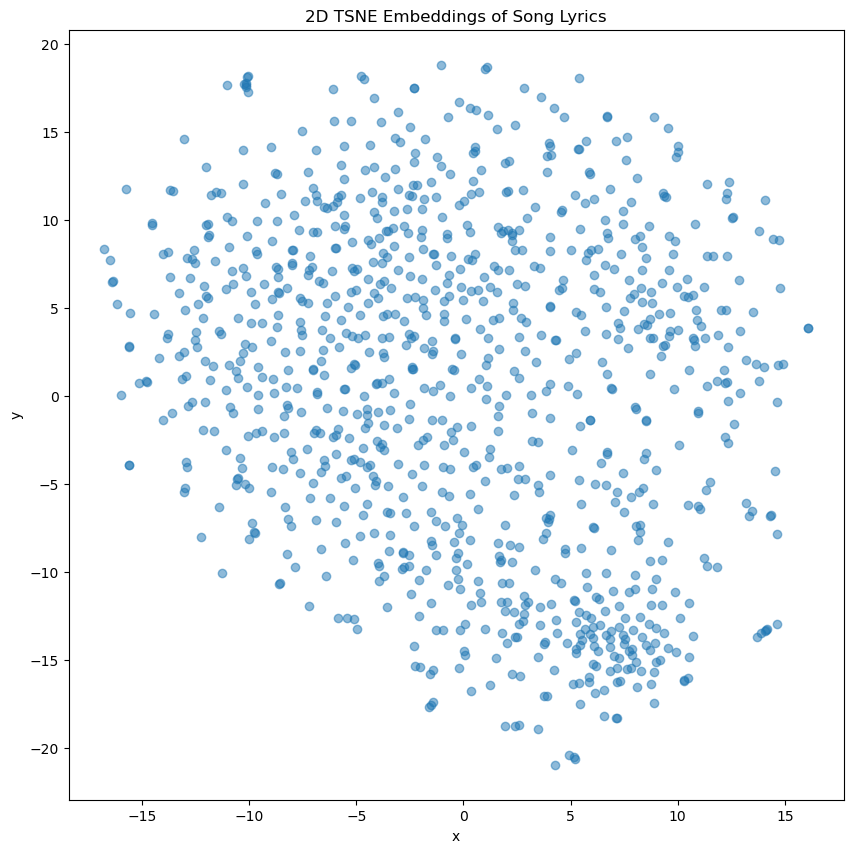

In [95]:
# visualize the embeddings using TSNE

import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=50)

# Fit and transform the embeddings using TSNE
embeddings_2d = tsne.fit_transform(test_df_ebd)

# Create a DataFrame for the 2D embeddings

embedding_2d_df = pd.DataFrame(embeddings_2d, columns=['x', 'y'], index=test_df_ebd.index)

# Plot the 2D embeddings

plt.figure(figsize=(10, 10))
plt.scatter(embedding_2d_df['x'], embedding_2d_df['y'], alpha=0.5)
plt.title('2D TSNE Embeddings of Song Lyrics')
plt.xlabel('x')
plt.ylabel('y')
plt.show()



References:

https://cookbook.openai.com/examples/zero-shot_classification_with_embeddings

https://platform.openai.com/docs/guides/embeddings/use-cases

https://cookbook.openai.com/examples/question_answering_using_embeddings

# 

## Themes

Using a similar pipeline, we can ask GPT to code the lyric into themes

Procedure:
- Select some `themes` we want to investigate (this is related to our interest and literature review)
- Construct prompts --- just like how you are going to use ChatGPT, but this time, you have to ensure she's replying with a consistant output that fit your tasks requirement. During our project exploration, we tried many way to prompt it, and we are presenting here is a *somehow* reliable one we used in the end.

In future project with more time and budget, it is more sensible to cross validate the coding with different strategy:
- More than one-shot coding
- various prompts
- more models
- use sub sample of the lyrics 

In [99]:
themes = [
         "Religion",
         "Love", 
         "Heartbreak", 
         "Family",
         "Individuality", 
         "Friendship",
         "Community",
         "Violence",
         "Sexuality",
         "Celebration", 
         "Struggle",
         "Wealth",
         "Adventure",
         "Fantasy"
         "Nostalgia",
         "Nature",
         "Politics",
         "Feminism"  
]

In [107]:
# rank the themes in alphabetical order
themes.sort()
themes

['Adventure',
 'Celebration',
 'Community',
 'Family',
 'FantasyNostalgia',
 'Feminism',
 'Friendship',
 'Heartbreak',
 'Individuality',
 'Love',
 'Nature',
 'Politics',
 'Religion',
 'Sexuality',
 'Struggle',
 'Violence',
 'Wealth']

### Here is the main function for prompting and request from OpenAI


- To modify the prompt: edit the messages section accordingly. [Link to documentation](https://platform.openai.com/docs/guides/text-generation)

In [108]:
import pandas as pd
import json
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed


def tag_lyrics_with_theme(row, themes):
    """
    Tag the lyrics of a song with the relevant themes using OpenAI's GPT-3.5 chat model.

    Args:
    - row: A row of the DataFrame containing the song title and lyrics
    - themes: A list of themes to be tagged

    Returns:
    - song_title: The title of the song
    - themes_identified: The themes identified in the lyrics by GPT-3.5

    """
    song_title = row['song']
    lyrics = row['lyrics']
    theme_list = ", ".join(themes)
    
    messages = [
        {"role": "system", "content": f"""
        Read the lyrics of the song titled '{song_title}'. Based on the content and emotions expressed in the lyrics, 
        identify which of the following themes are represented: 
        *** {theme_list} ***. 

        Please select and respond with ALL the relevant themes from the above list in a comma-separated format. 
        In your respond, only include words from the themes given above.
        """},
        {"role": "user", "content": lyrics}
    ]

    # Send the query to OpenAI's GPT-3.5 using the chat model
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages,
        max_tokens=1024,
        temperature=0.7,
    )
    # Extracting the relevant part of the response
    themes_identified = response.choices[0].message.content.strip()

    return song_title, themes_identified

def tag_song_lyrics_with_themes(df, themes, output_file_path="song_themes.json", workers=10):
    
    with open(output_file_path, 'w') as outfile, ThreadPoolExecutor(max_workers=workers) as executor:
        # Submit all the tasks to the executor
        future_to_song = {executor.submit(tag_lyrics_with_theme, row, themes): row['song'] for _, row in df.iterrows()}
        
        # Process the futures as they complete
        for future in tqdm(as_completed(future_to_song), total=len(df), desc="Tagging songs"):
            song_title = future_to_song[future]
            try:
                song_title, themes_identified = future.result()
                # Write the song title and identified themes as a JSON object to the file
                song_theme_json = json.dumps({song_title: themes_identified})
                outfile.write(song_theme_json + '\n')
            except Exception as exc:
                print(f'{song_title} generated an exception: {exc}')

    print(f"Themes tagged and saved to {output_file_path}")

#### Again, test with a small sample first

In [106]:
sample_drop = df_drop.sample(100)

tag_song_lyrics_with_themes(sample_drop, themes, "song_themes_100.json", workers=10)

Tagging songs:   0%|          | 0/100 [00:00<?, ?it/s]

Tagging songs: 100%|██████████| 100/100 [00:05<00:00, 18.70it/s]

Themes tagged and saved to song_themes_100.json


Fully operate on the entire dataframe

In [109]:
# operate fully on the entire dataframe

tag_song_lyrics_with_themes(df_drop, themes, "song_themes_26211.json", workers=40)

Tagging songs: 100%|██████████| 26221/26221 [28:43<00:00, 15.21it/s]

Themes tagged and saved to song_themes_26211.json


In total, it take around 30 minutes and 8 dollars ask gpt-3.5-turbo to code the themes.

NOTE: the visualization and exploration of themes are demonstrated in the visualization. (see `data_merge.ipynb` and visualization folder)